In [ ]:
# !pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "./"

!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip cell-images-for-detecting-malaria.zip

# Import library

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, RandomFlip, RandomZoom, RandomRotation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


import pathlib
from PIL import Image

from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
sns.set_theme()

# PATH = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/'
PATH = 'cell_images/cell_images/'
p = pathlib.Path(PATH)
pos = list(p.glob('Parasitized/*.png'))
neg = list(p.glob('Uninfected/*.png'))

print(len(pos), len(neg))

13779 13779


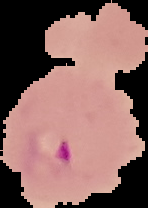

In [ ]:

img = Image.open('cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png')
img

# EDA

In [ ]:
# create dataframe for dataset, include: filename, width, height, path, class
filenames = []
width = []
height = []
paths = []
classes = []

for i in tqdm(pos):
    name = i.stem
    parts = i.parts
    path = '/'.join(parts[-2:])
    class_ = 1

    w, h = Image.open(i).size

    filenames.append(name)
    width.append(w)
    height.append(h)
    paths.append(path)
    classes.append(class_)
#     print(name, path)

for i in tqdm(neg):
    name = i.stem
    parts = i.parts
    path = '/'.join(parts[-2:])
    class_ = 0

    w, h = Image.open(i).size

    filenames.append(name)
    width.append(w)
    height.append(h)
    paths.append(path)
    classes.append(class_)

d = {
    'filename': filenames,
    'width': width,
    'height': height,
    'path': paths,
    'class': classes,
}
df = pd.DataFrame.from_dict(d)
df

100%|██████████| 13779/13779 [00:01<00:00, 9790.33it/s]


,filename,width,height,path,class
0,C116P77ThinF_IMG_20150930_171219_cell_88,112,130,Parasitized/C116P77ThinF_IMG_20150930_171219_c...,1
1,C180P141NThinF_IMG_20151201_170110_cell_10,121,136,Parasitized/C180P141NThinF_IMG_20151201_170110...,1
2,C182P143NThinF_IMG_20151201_171836_cell_169,145,142,Parasitized/C182P143NThinF_IMG_20151201_171836...,1
3,C129P90ThinF_IMG_20151004_134700_cell_26,142,139,Parasitized/C129P90ThinF_IMG_20151004_134700_c...,1
4,C97P58ThinF_IMG_20150917_152032_cell_155,154,118,Parasitized/C97P58ThinF_IMG_20150917_152032_ce...,1
...,...,...,...,...,...
27553,C161P122ThinF_IMG_20151116_101059_cell_69,118,121,Uninfected/C161P122ThinF_IMG_20151116_101059_c...,0
27554,C108P69ThinF_IMG_20150924_225511_cell_10,148,154,Uninfected/C108P69ThinF_IMG_20150924_225511_ce...,0
27555,C206ThinF_IMG_20151029_140538_cell_278,154,136,Uninfected/C206ThinF_IMG_20151029_140538_cell_...,0
27556,C5NThinF_IMG_20150609_122020_cell_37,136,142,Uninfected/C5NThinF_IMG_20150609_122020_cell_3...,0


In [ ]:
df.describe()

,width,height,class
count,27558.000000,27558.000000,27558.000000
mean,132.487154,132.983453,0.500000
std,20.015949,20.619650,0.500009
min,46.000000,40.000000,0.000000
25%,121.000000,121.000000,0.000000
50%,130.000000,130.000000,0.500000
75%,142.000000,145.000000,1.000000
max,394.000000,385.000000,1.000000


In [ ]:
df['width'].value_counts()
df['height'].value_counts()


130    2050
124    1857
127    1852
133    1827
136    1765
       ... 
289       1
325       1
259       1
268       1
49        1
Name: height, Length: 81, dtype: int64

In [ ]:
df.sample(10)

,filename,width,height,path,class
21689,C83P44ThinF_IMG_20150817_133218_cell_113,157,127,Uninfected/C83P44ThinF_IMG_20150817_133218_cel...,0
26444,C156P117ThinF_IMG_20151115_154435_cell_206,145,118,Uninfected/C156P117ThinF_IMG_20151115_154435_c...,0
11621,C129P90ThinF_IMG_20151004_133329_cell_95,124,139,Parasitized/C129P90ThinF_IMG_20151004_133329_c...,1
11130,C152P113ThinF_IMG_20151115_124323_cell_161,109,112,Parasitized/C152P113ThinF_IMG_20151115_124323_...,1
16677,C90P51ThinF_IMG_20150821_115310_cell_10,118,142,Uninfected/C90P51ThinF_IMG_20150821_115310_cel...,0
2099,C91P52ThinF_IMG_20150821_123116_cell_196,163,169,Parasitized/C91P52ThinF_IMG_20150821_123116_ce...,1
21693,C230ThinF_IMG_20151112_150621_cell_213,106,130,Uninfected/C230ThinF_IMG_20151112_150621_cell_...,0
22283,C219ThinF_IMG_20151106_145927_cell_92,121,130,Uninfected/C219ThinF_IMG_20151106_145927_cell_...,0
12786,C180P141NThinF_IMG_20151201_165659_cell_26,136,166,Parasitized/C180P141NThinF_IMG_20151201_165659...,1
17920,C218ThinF_IMG_20151106_143940_cell_58,148,172,Uninfected/C218ThinF_IMG_20151106_143940_cell_...,0


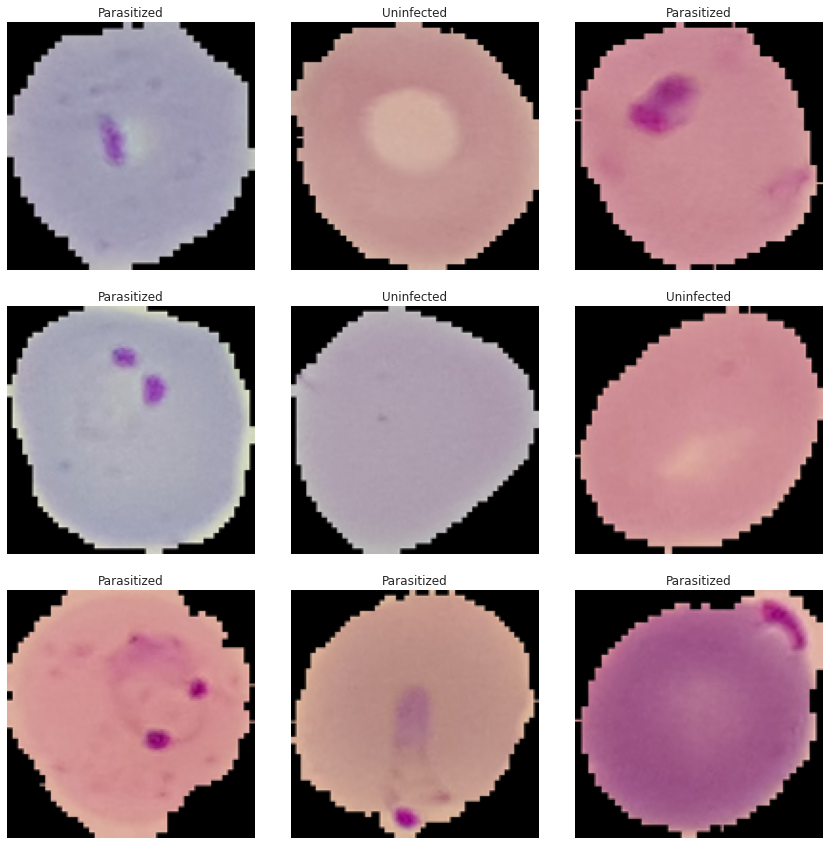

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def display(df):
    labels = ['Parasitized' if i == 1 else 'Uninfected' for i in df['class']]
    list_imgs = df['path']
    fig = plt.figure(figsize=(15., 15.))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(3, 3),  # creates 3x3 grid of axes
                    axes_pad=0.5,        # pad between axes in inch.
                    )

    for ax, im, label in zip(grid,[np.array(Image.open(PATH + i).resize((130, 130))) for i in list_imgs], labels):
        # Iterating over the grid returns the Axes.
        ax.set_axis_off()
        ax.imshow(im)
        ax.set_title(f'{label}')
    plt.savefig('./demo.jpg')
    plt.show()

display(df.sample(9))

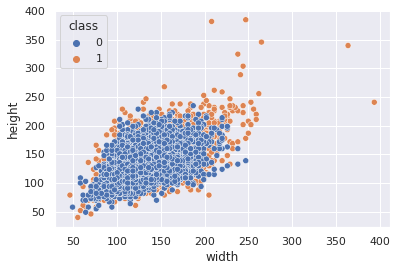

In [ ]:
scatter_plot = sns.scatterplot(data=df, x='width', y='height', hue='class')
fig = scatter_plot.get_figure()
fig.savefig('./image_size_distribution.jpg')
scatter_plot

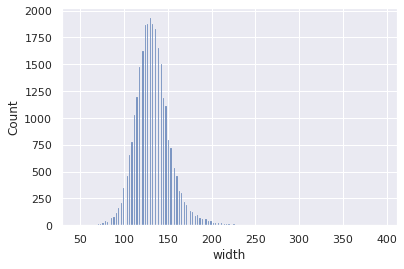

In [ ]:
plot = sns.histplot(data = df, x='width')
fig = plot.get_figure()
fig.savefig('./width_distribution.jpg')
plot

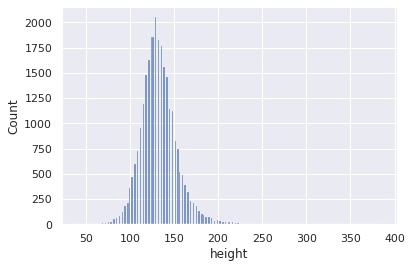

In [ ]:
plot = sns.histplot(data = df, x='height')
fig = plot.get_figure()
fig.savefig('./height_distribution.jpg')
plot

In [ ]:
sns.histplot(data = df, x = 'class')

# Set parameter for preprocessing

In [ ]:
batch_size = 64
img_width = 130
img_height = 130
data_dir = PATH
seed = 2022

# Import training dataset

In [ ]:
train_ds = image_dataset_from_directory( data_dir,
                                        validation_split=0.2,
                                        subset="training",
                                        seed=seed,
                                        image_size=(img_height, img_width),
                                        batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


# Validation dataset is 20% of total dataset

In [ ]:
val_ds = image_dataset_from_directory(data_dir,
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=seed,
                                      image_size=(img_height, img_width),
                                      batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.
['Parasitized', 'Uninfected']


# Preview training dataset

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [ ]:
normalization_layer = Rescaling(1./255)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8960373


# Build model

In [ ]:
num_classes = len(class_names)

model = Sequential([
                    Rescaling(1./255),
                    Conv2D(16, 3, activation='relu', padding='same'),
                    MaxPooling2D(),
                    Conv2D(32, 3, activation='relu', padding='same'),
                    MaxPooling2D(),
                    Conv2D(64, 3, activation='relu', padding='same'),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(num_classes)
                  ])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train model

In [ ]:
epochs=10
callback = EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback]
                  )

Epoch 1/10
345/345 [==============================] - 368s 1s/step - loss: 0.4367 - accuracy: 0.7808 - val_loss: 0.2184 - val_accuracy: 0.9209
Epoch 2/10
345/345 [==============================] - 349s 1s/step - loss: 0.1799 - accuracy: 0.9368 - val_loss: 0.1695 - val_accuracy: 0.9379
Epoch 3/10
345/345 [==============================] - 345s 1000ms/step - loss: 0.1561 - accuracy: 0.9468 - val_loss: 0.1677 - val_accuracy: 0.9530
Epoch 4/10
345/345 [==============================] - 341s 988ms/step - loss: 0.1317 - accuracy: 0.9546 - val_loss: 0.1595 - val_accuracy: 0.9543
Epoch 5/10
345/345 [==============================] - 343s 992ms/step - loss: 0.1126 - accuracy: 0.9629 - val_loss: 0.1512 - val_accuracy: 0.9597
Epoch 6/10
345/345 [==============================] - 347s 1s/step - loss: 0.0922 - accuracy: 0.9684 - val_loss: 0.1509 - val_accuracy: 0.9550
Epoch 7/10
345/345 [==============================] - 345s 998ms/step - loss: 0.0731 - accuracy: 0.9747 - val_loss: 0.2133 - val_acc

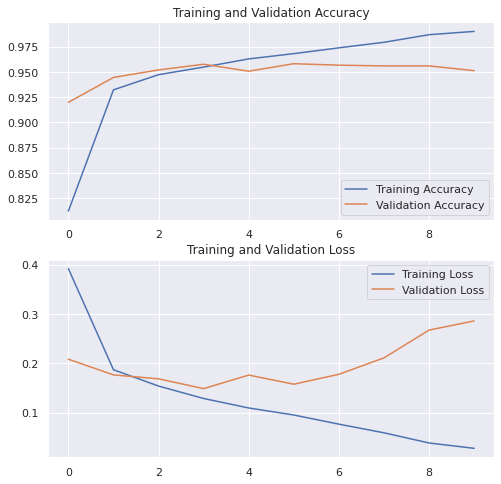

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluation results

In [ ]:
y_test = np.concatenate([l for _, l in val_ds])
y_test = to_categorical(y_test)

In [ ]:
y_true

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
preds = model.predict(val_ds)
print(preds.shape) # which means the predictions return in one-hot encoding format
preds = np.argmax(preds, axis=1)
print(preds.shape)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, preds, target_names=class_names))

(5511, 2)
(5511,)
              precision    recall  f1-score   support

 Parasitized       0.51      0.51      0.51      2820
  Uninfected       0.49      0.49      0.49      2691

    accuracy                           0.50      5511
   macro avg       0.50      0.50      0.50      5511
weighted avg       0.50      0.50      0.50      5511



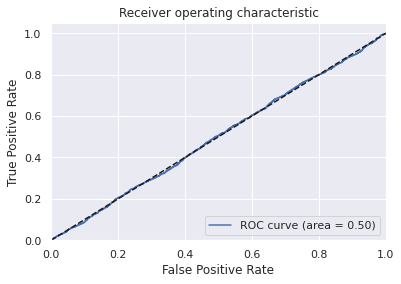

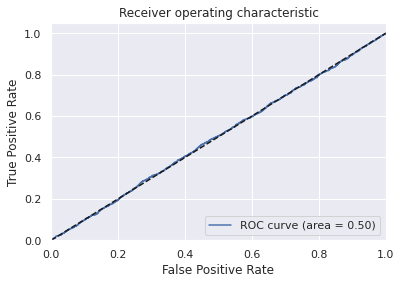

In [ ]:
# Compute ROC curve and ROC area for each class


y_score = model.predict(val_ds) # get the prediction probabilities
y_test = np.concatenate([l for i, l in val_ds])
y_test = to_categorical(y_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Fine tune

In [ ]:
data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)
normalization_layer = Rescaling(1./255)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
image, label = next(iter(train_ds))
# plt.imshow(image[0])
print(image[0].shape)
plt.imshow(image[0].numpy().astype("uint8"))

In [ ]:
for i in range(9):
    augmented_images = data_augmentation(image[0])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = 2
model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(16, 3, activation='relu', padding='same'),
  MaxPooling2D(),

  Conv2D(32, 3, activation='relu', padding='same'),
  MaxPooling2D(),

  Conv2D(64, 3, activation='relu', padding='same'),
  MaxPooling2D(),

  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 45
callback = EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/45
345/345 [==============================] - 10s 27ms/step - loss: 0.5010 - accuracy: 0.7408 - val_loss: 0.2178 - val_accuracy: 0.9187
Epoch 2/45
345/345 [==============================] - 9s 26ms/step - loss: 0.2052 - accuracy: 0.9285 - val_loss: 0.1707 - val_accuracy: 0.9441
Epoch 3/45
345/345 [==============================] - 9s 26ms/step - loss: 0.1775 - accuracy: 0.9411 - val_loss: 0.1616 - val_accuracy: 0.9550
Epoch 4/45
345/345 [==============================] - 9s 26ms/step - loss: 0.1673 - accuracy: 0.9481 - val_loss: 0.1477 - val_accuracy: 0.9546
Epoch 5/45
345/345 [==============================] - 9s 26ms/step - loss: 0.1559 - accuracy: 0.9518 - val_loss: 0.1397 - val_accuracy: 0.9579
Epoch 6/45
345/345 [==============================] - 9s 26ms/step - loss: 0.1454 - accuracy: 0.9544 - val_loss: 0.1556 - val_accuracy: 0.9563
Epoch 7/45
345/345 [==============================] - 9s 26ms/step - loss: 0.1454 - accuracy: 0.9531 - val_loss: 0.1279 - val_accuracy: 0.959

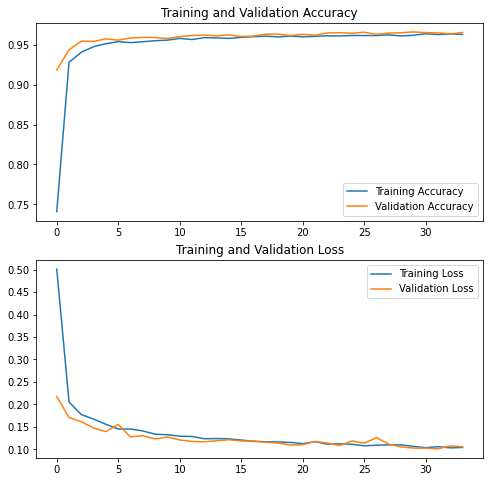

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_score

array([[-8.392014  ,  4.772137  ],
       [10.159624  , -3.8273947 ],
       [-5.62804   ,  1.6841255 ],
       ...,
       [-1.2928123 , -0.30037916],
       [-4.5619197 ,  1.4681252 ],
       [12.662302  , -4.8042984 ]], dtype=float32)

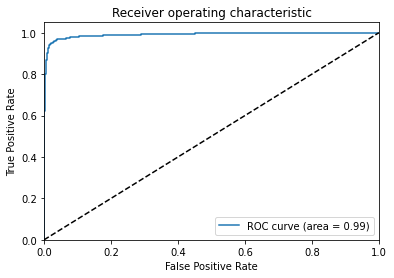

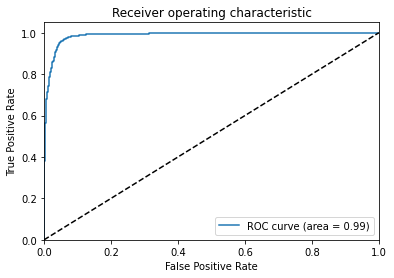

In [ ]:
# Compute ROC curve and ROC area for each class
y_score = model.predict(val_ds) # get the prediction probabilities
y_test = np.concatenate([l for i, l in val_ds])
y_test = to_categorical(y_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from sklearn.metrics import classification_report

preds = model.predict(val_ds)
print(preds.shape) # which means the predictions return in one-hot encoding format
preds = np.argmax(preds, axis=1)
print(preds.shape)
y_true = np.argmax(y_test, axis=1)
print(y_true.shape)
print(classification_report(y_true, preds, target_names=['Parasitized', 'Uninfected']))

(5511, 2)
(5511,)
(5511,)
              precision    recall  f1-score   support

 Parasitized       0.98      0.95      0.97      2820
  Uninfected       0.95      0.98      0.97      2691

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511



# Transfer learning mobilenet V2

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
BATCH_SIZE = 32
IMG_SIZE = (120, 120)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


In [ ]:
base_model.trainable = False


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
base_model.trainable = True


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()